# South Carolina
We will be analyzing the congressional district map passed in 2021 in South Carolina followwing the 2020 census. Currently South Carolina's congressional map is in litigation so we want to examine how that could have effected the 2024 U.S. House election.

## Import Required Packages

In [ ]:
# For working with graphs
import networkx as nx

# For making plots
import matplotlib.pyplot as plt
import numpy as np

# Needed for gerrychain
import gerrychain   
from gerrychain import Graph, Partition, proposals, updaters, constraints, accept, MarkovChain, GeographicPartition
from gerrychain.updaters import cut_edges, Tally
from gerrychain.tree import recursive_tree_part
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
import geopandas as gpd
import pandas as pd

# Other necessary packages
import random
import maup

## Analysis of maps by senate voting

Now that we have set up the data, we can start our analysis!

We want to determine what party would have won the election for the U.S. House of Representative in each district for each of the two maps we have for Georgia. However, instead of using House candidates, we will be using U.S. Senate candidates because those were elected across the whole state. Thus, we will be using the Senate election as a placeholder for the House election because in the next party, once we move the congressional district boundary using a random walk, the candidates for the House would change. We are assuming voters would vote by party so we will use a statewide election where there were two candidates, one from each party, to determine how each voters would vote in a new House election.

In [2]:
# Read in our saved data frame
sc_data_gdf = gpd.read_file("save-new-data/sc-election-census-data-by-precincts.shp")

In [3]:
# Read in our 2021 and 2023 congressional district gdp for district boundaries
sc_2021_gdf = gpd.read_file("S865_Congress/S865_Congress.shp")

### 2021 Congressional Map

We will use the U.S. Senate election to see what party the candidate for the U.S. House would have been elected from based on the 2021 congressional districting map. In 2022, there were two main candidates that ran for the U.S. Senate: Democrat Krystle Matthews (G22USSDMAT) and Republican Tim Scott (G22USSRSCO).

In [4]:
# Group by congressional district and calculate total votes for each candidate
district_totals = sc_data_gdf.groupby('DIST2021')[['G22USSDMAT', 'G22USSRSCO']].sum()

# Determine the winning party in each district
district_totals['Winner-2021'] = np.where(district_totals['G22USSDMAT'] > district_totals['G22USSRSCO'], "Democrat", "Republican")

# Reset index to turn District back into a column (optional)
district_totals_2021 = district_totals.reset_index()

print(district_totals_2021)

   DIST2021  G22USSDMAT  G22USSRSCO Winner-2021
0         0      102747      166643  Republican
1         1       94092      151076  Republican
2         2       58967      177332  Republican
3         3       76874      154642  Republican
4         4       84115      156327  Republican
5         5      123878       87239    Democrat
6         6       84651      169258  Republican


In [5]:
# Count the number of districts won by each party
winner_summary_2021 = district_totals_2021['Winner-2021'].value_counts()

print(winner_summary_2021)

Winner-2021
Republican    6
Democrat      1
Name: count, dtype: int64


In [6]:
sc_data_gdf = sc_data_gdf.merge(district_totals_2021[["DIST2021", "Winner-2021"]], on='DIST2021', how='left')

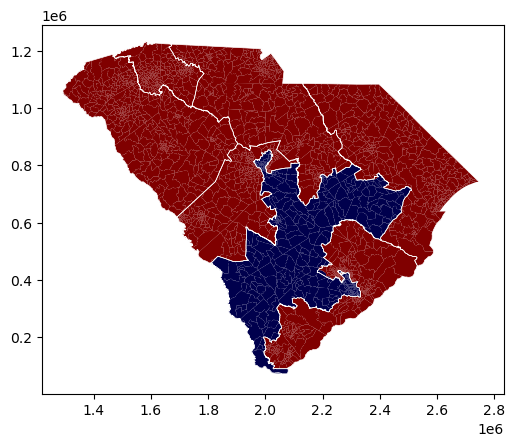

In [7]:
fig, ax = plt.subplots()

# Plot the units with the vote percentage as color
sc_data_gdf.plot(column = "Winner-2021", ax=ax, cmap = "seismic")

# Overlay districts
sc_2021_gdf = sc_2021_gdf.to_crs("EPSG:2273")
sc_2021_gdf.boundary.plot(ax=ax, color='white', linewidth=0.5)

# Save the figure as a PNG file
plt.savefig('./graphics/sc-2021-winner-dist.png', dpi=300, bbox_inches='tight') 
plt.show()

### Setting up and running our Random Walk

In [8]:
sc_graph = Graph.from_file("save-new-data/sc-election-census-data-by-precincts.shp")

In [9]:
# Make an initial districting plan

num_dist = 7 # Number of Congressional Districts in South Carolina
tot_pop = sum([sc_graph.nodes()[v]['TOTPOP'] for v in sc_graph.nodes()])
ideal_pop = tot_pop/num_dist
pop_tolerance = 0.02
initial_plan = recursive_tree_part(sc_graph, range(num_dist), ideal_pop, 'TOTPOP', pop_tolerance, 10)

The case against South Carolina's congressional districting plan claimed that the plan was a partisan gerrymander. But a previous 
case that was prejudicely dismissed argued that the plan was a racial gerrmander. For those reasons we will examine the black population in addition to the senate election.

In [10]:
#Set up partition object
initial_partition = Partition(
    sc_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("G22USSRSCO", alias = "R Votes"), 
        "D Votes": Tally("G22USSDMAT", alias = "D Votes")
    }
) 

In [11]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [12]:
# We contrain the opulation to say with the tolarance we set for an ideal district population
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [13]:
# Now we create our chain
our_random_walk = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 10000
)

In [14]:
bmaj_ensemble = []
d_ensemble = [] 
bpop = [] 
dvpop = []

for current_plan in our_random_walk:    
    # Calculate number of black-majority districts 
    # Add to ensemble
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1
    bmaj_ensemble.append(num_maj_black)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0
    for i in range(num_dist):
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1
    d_ensemble.append(d)

    # Calculate the percentage of black population for each district at each step
    bpop_this_step = []
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)
    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    # Calculate the percentage of democratic voters for each district at each step
    dv_this_step = []
    for i in range(num_dist):
        dv_perc = current_plan["D Votes"][i]/ (current_plan["R Votes"][i] + current_plan["D Votes"][i])
        dv_this_step.append(dv_perc)
    dv_this_step.sort()
    dvpop.append(dv_this_step)

bpop_rand = np.array(bpop)
dvpop_rand = np.array(dvpop)

### Analysis

In the 2021 congressional districting plans there was 1 district that elected democratic representatives for the House. Let's see how many democratic districts are likely within the ensemble.

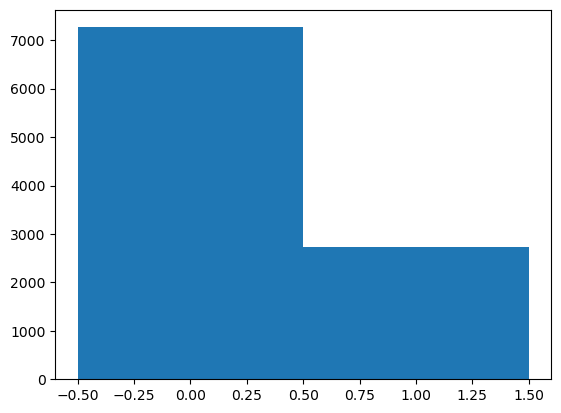

In [15]:
plt.figure()
plt.hist(d_ensemble, bins = [x + 0.5 for x in range(min(set(d_ensemble)) - 1, max(set(d_ensemble)) + 1)])

# Save the figure as a PNG file
plt.savefig('./graphics/sc-rand-d-ensemble.png', dpi=300, bbox_inches='tight') 
plt.show()

We see that 0 democratic districts are most likely.

Now, let's look at black majority districts.

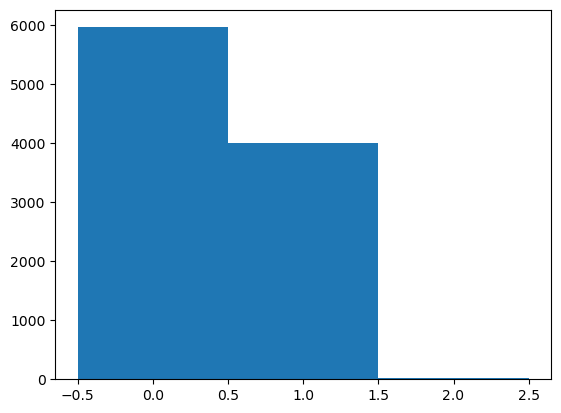

In [16]:
plt.figure()
plt.hist(bmaj_ensemble, bins = [x + 0.5 for x in range(min(set(bmaj_ensemble)) - 1, max(set(bmaj_ensemble)) + 1)])

# Save the figure as a PNG file
plt.savefig('./graphics/sc-rand-bmaj-ensemble.png', dpi=300, bbox_inches='tight') 
plt.show()

The ensemble has mostly 0 Black-majority districts but 1 is somewhat close. Now let's see how many exist in the 2021 congressional plan.

In [17]:
# Group by congressional district and calculate total votes for each candidate
pop_totals = sc_data_gdf.groupby('DIST2021')[['TOTPOP', 'POPBAA']].sum()

# Determine the winning party in each district
pop_totals['BPER'] = pop_totals['POPBAA'] / pop_totals['TOTPOP']

# Reset index to turn District back into a column (optional)
pop_totals = pop_totals.reset_index()

print(pop_totals)

   DIST2021  TOTPOP  POPBAA      BPER
0         0  727020  124365  0.171061
1         1  733016  185124  0.252551
2         2  731546  125557  0.171632
3         3  731387  135367  0.185083
4         4  731348  176067  0.240743
5         5  732612  344153  0.469762
6         6  731488  189894  0.259600


In [18]:
sc_data_gdf = sc_data_gdf.merge(pop_totals[["DIST2021", "BPER"]], on='DIST2021', how='left')

In [19]:
num_maj_black = 0
for i in pop_totals["BPER"]:
    if i >= 0.37: 
        num_maj_black += 1

print("Black majority districts in 2021 plan:", num_maj_black)

Black majority districts in 2021 plan: 1


So it seems like the 2021 may or may not have been racially or partisanly gerrymandered.

### Mixing Time

#### Random Walk from 2021 Plan

In [20]:
#Set up partition object
initial_partition = Partition(
    sc_graph, # dual graph
    assignment = "DIST2021", # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("G22USSRSCO", alias = "R Votes"), 
        "D Votes": Tally("G22USSDMAT", alias = "D Votes")
    }
) 

In [21]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [22]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [23]:
random_walk_2021 = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 10000
)

In [24]:
bmaj_ensemble = []
d_ensemble = [] 
bpop = [] 
dvpop = []

for current_plan in random_walk_2021:    
    # Calculate number of black-majority districts 
    # Add to ensemble
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1
    bmaj_ensemble.append(num_maj_black)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0
    for i in range(num_dist):
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1
    d_ensemble.append(d)

    # Calculate the percentage of black population for each district at each step
    bpop_this_step = []
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)
    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    # Calculate the percentage of democratic voters for each district at each step
    dv_this_step = []
    for i in range(num_dist):
        dv_perc = current_plan["D Votes"][i]/ (current_plan["R Votes"][i] + current_plan["D Votes"][i])
        dv_this_step.append(dv_perc)
    dv_this_step.sort()
    dvpop.append(dv_this_step)

bpop_2021 = np.array(bpop)
dvpop_2021 = np.array(dvpop)

#### Compare a boxplot of the results from black population and for democratic voting population

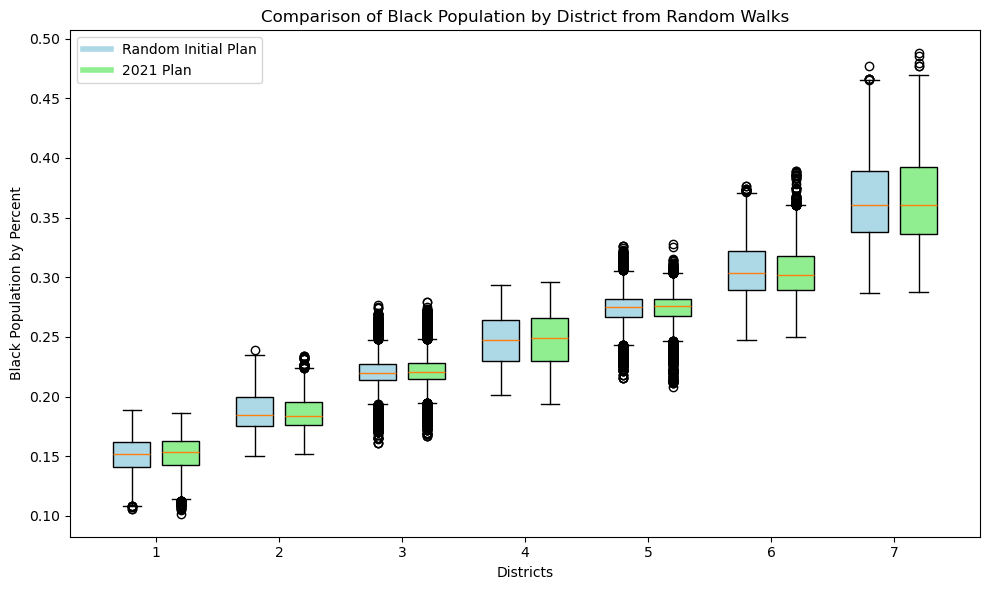

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_2021 = [x + 0.2 for x in range(1, num_dist + 1)]

# Plot boxplots for black population from random initial plan
ax.boxplot(bpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(bpop_2021, positions=positions_2021, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['Random Initial Plan', '2021 Plan'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Black Population by Percent')
ax.set_title('Comparison of Black Population by District from Random Walks')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('./graphics/sc-rws-bpop.png', dpi=300, bbox_inches='tight') 
plt.show()

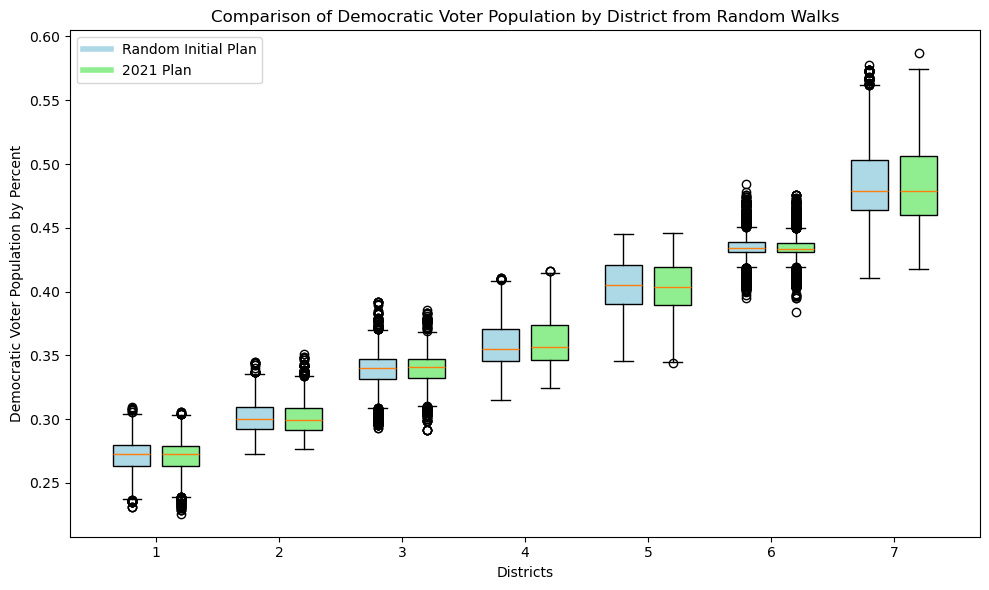

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot boxplots for black population from random initial plan
ax.boxplot(dvpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(dvpop_2021, positions=positions_2021, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['Random Initial Plan', '2021 Plan'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Democratic Voter Population by Percent')
ax.set_title('Comparison of Democratic Voter Population by District from Random Walks')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('./graphics/sc-rws-dvpop.png', dpi=300, bbox_inches='tight') 
plt.show()

### Run random initial one for more 20,000 steps instead of 10,0000

In [27]:
#Set up partition object
initial_partition = Partition(
    sc_graph, # dual graph
    assignment = initial_plan, # initial districting plan
    updaters = { 
        "district population": Tally("TOTPOP", alias = "district population"), 
        "district BPOP": Tally("POPBAA", alias = "district BPOP"),
        "R Votes": Tally("G22USSRSCO", alias = "R Votes"), 
        "D Votes": Tally("G22USSDMAT", alias = "D Votes")
    }
) 

In [28]:
rw_proposal = partial(recom, ## how you choose a next districting plan
                      pop_col = "TOTPOP", ## What data describes population? 
                      pop_target = ideal_pop, ## What the target/ideal population is for each district 
                                              ## (we calculated ideal pop above)
                      epsilon = pop_tolerance,  ## how far from ideal population you can deviate
                                              ## (we set pop_tolerance above)
                      node_repeats = 1 ## number of times to repeat bipartition.  Can increase if you get a BipartitionWarning
                      )

In [29]:
population_constraint = constraints.within_percent_of_ideal_population(
    initial_partition, 
    pop_tolerance, 
    pop_key = "district population"
    )

In [30]:
random_walk_more_steps = MarkovChain(
    proposal = rw_proposal, 
    constraints = [population_constraint],
    accept = always_accept, # accepts every proposed plan that meets population criteria
    initial_state = initial_partition, 
    total_steps = 20000
)

In [31]:
bmaj_ensemble = []
d_ensemble = [] 
bpop = []
dv_pop = []

for current_plan in random_walk_more_steps:    
    # Calculate number of black-majority districts 
    # Add to ensemble
    num_maj_black = 0
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/current_plan["district population"][i]
        if b_perc >= 0.37:
            num_maj_black += 1
    bmaj_ensemble.append(num_maj_black)

    # Calculate number of districts with more Democratic votes than Republican votes
    d = 0
    for i in range(num_dist):
        if current_plan["R Votes"][i] < current_plan["D Votes"][i]: 
            d = d + 1
    d_ensemble.append(d)

    # Calculate the percentage of black population for each district at each step
    bpop_this_step = []
    for i in range(num_dist):
        b_perc = current_plan["district BPOP"][i]/ current_plan["district population"][i]
        bpop_this_step.append(b_perc)
    bpop_this_step.sort()
    bpop.append(bpop_this_step)

    # Calculate the percentage of democratic voters for each district at each step
    dv_this_step = []
    for i in range(num_dist):
        dv_perc = current_plan["D Votes"][i]/ (current_plan["D Votes"][i] + current_plan["R Votes"][i])
        dv_this_step.append(dv_perc)
    dv_this_step.sort()
    dvpop.append(dv_this_step)

bpop_more_steps = np.array(bpop)
dvpop_more_steps = np.array(dvpop)

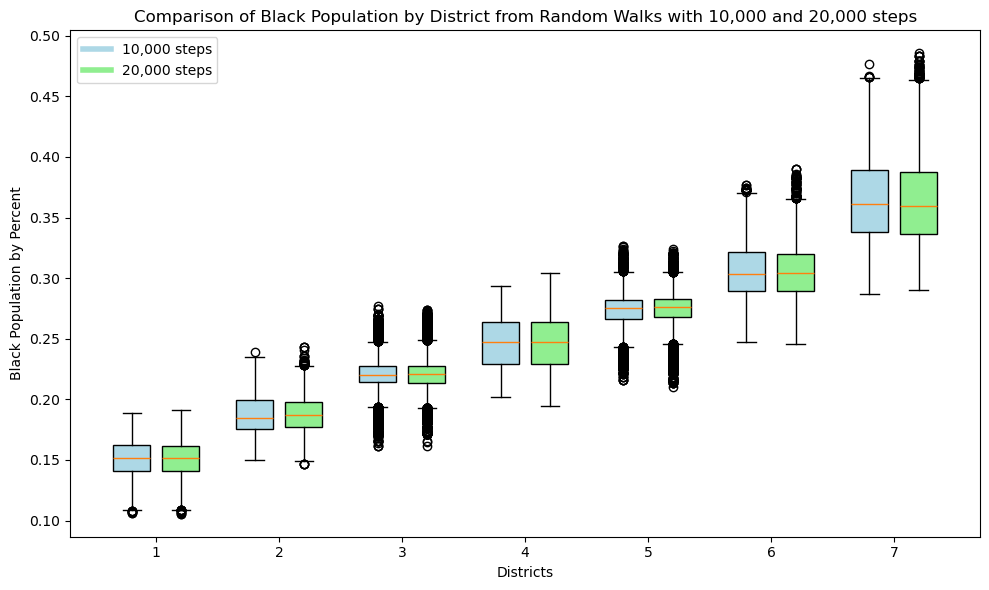

In [32]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)] 
positions_more_steps = [x + 0.2 for x in range(1, num_dist + 1)] 

# Plot boxplots for black population from random initial plan with 10000 steps
ax.boxplot(bpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(bpop_more_steps, positions=positions_more_steps, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['10,000 steps', '20,000 steps'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Black Population by Percent')
ax.set_title('Comparison of Black Population by District from Random Walks with 10,000 and 20,000 steps')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('./graphics/sc-steps-bpop.png', dpi=300, bbox_inches='tight') 
plt.show()

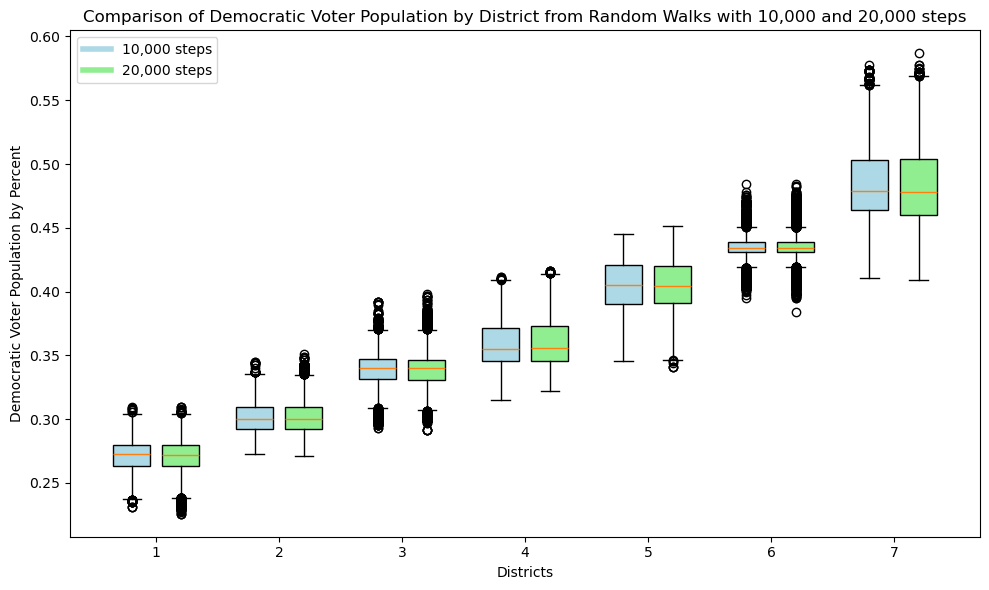

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

positions_rand = [x - 0.2 for x in range(1, num_dist + 1)]  
positions_more_steps = [x + 0.2 for x in range(1, num_dist + 1)] 

# Plot boxplots for black population from random initial plan with 10000 steps
ax.boxplot(dvpop_rand, positions=positions_rand, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightblue"), 
           tick_labels=[f'Dist {i+1}' for i in range(num_dist)])

# Plot boxplots for black population from 2021 initial plan
ax.boxplot(dvpop_more_steps, positions=positions_more_steps, widths=0.3, patch_artist=True, boxprops=dict(facecolor="lightgreen"))

# Set the x-ticks at the center of the two boxplots for each district
ax.set_xticks(range(1, num_dist + 1))
ax.set_xticklabels([f'{i+1}' for i in range(num_dist)])

# Add legend
ax.legend([plt.Line2D([0], [0], color="lightblue", lw=4),
           plt.Line2D([0], [0], color="lightgreen", lw=4)],
          ['10,000 steps', '20,000 steps'])

# Set labels and title
ax.set_xlabel('Districts')
ax.set_ylabel('Democratic Voter Population by Percent')
ax.set_title('Comparison of Democratic Voter Population by District from Random Walks with 10,000 and 20,000 steps')

plt.tight_layout()

# Save the figure as a PNG file
plt.savefig('./graphics/sc-steps-dvpop.png', dpi=300, bbox_inches='tight') 
plt.show()

Looks like our random walk ran for long enough.